In [1]:
import pandas as pd

# Carica il dataset
df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")  # Adatta path se necessario

# Calcola % NaN per colonna
nan_percent = df.isna().mean().sort_values(ascending=False) * 100
nan_df = nan_percent[nan_percent > 0].to_frame(name="Percentuale NaN")
nan_df.head(20)  # Mostra le 20 peggiori

,Percentuale NaN
Updrs-III,17.883212
Duration (years),6.204380
"Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )",5.839416
Age Onset,5.839416
MSE AP,4.744526
MSE ML,4.744526
MSE V,4.744526
iHR ML,4.014599
iHR AP,4.014599
iHR V,4.014599


In [2]:
# 🔹 Variabili chiave da tracciare per missingness
vars_to_flag = [
    "Updrs-III", "Duration (years)", "AgeOnset", "OnsetCategory",
    "DoubleSupport", "SingleSupport", "GaitSpeed", "StrideLength"
]

# 🔹 Crea colonne binarie che indicano se il valore era mancante
for col in vars_to_flag:
    if col in df.columns:
        safe_colname = col.replace(" ", "_").replace("-", "_")
        df[f"{safe_colname}_was_missing"] = df[col].isna().astype(int)

# 🔹 Controllo rapido
df[[c for c in df.columns if "_was_missing" in c]].head()

,Updrs_III_was_missing,Duration_(years)_was_missing
0,1,0
1,0,0
2,0,0
3,0,0
4,1,0


In [ ]:
# Colonne flag create
flag_cols = [c for c in df.columns if c.endswith("_was_missing")]

# Quanti flag per soggetto
df["missing_flags_sum"] = df[flag_cols].sum(axis=1)

# Distribuzione globale
print("Distribuzione numero di flag per soggetto:")
print(df["missing_flags_sum"].value_counts().sort_index())

# Distribuzione per classe (se target_bin presente)
if "target_bin" in df.columns:
    print("\nDistribuzione flag per classe:")
    print(df.groupby("target_bin")["missing_flags_sum"].describe().round(2))

# Quanti hanno almeno 1 flag
n_any = (df["missing_flags_sum"] > 0).sum()
print(f"\nSoggetti con ≥1 flag: {n_any} su {len(df)} "
      f"({n_any/len(df)*100:.1f}%)")

# (Facoltativo) Esporta un report veloce
df[["missing_flags_sum"] + flag_cols].to_csv("../tables/missing_flags_report.csv", index=False)

Distribuzione numero di flag per soggetto:
missing_flags_sum
0    213
1     56
2      5
Name: count, dtype: int64

Distribuzione flag per classe:
            count  mean   std  min  25%  50%  75%  max
target_bin                                            
0           164.0  0.24  0.50  0.0  0.0  0.0  0.0  2.0
1           110.0  0.24  0.43  0.0  0.0  0.0  0.0  1.0

Soggetti con ≥1 flag: 61 su 274 (22.3%)


In [4]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Colonne numeriche (escludi i flag *_was_missing)
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols_all if not c.endswith("_was_missing")]

# Colonne categoriche (object)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Imputazione numeriche -> mediana (robusta)
if len(num_cols) > 0:
    imputer_num = SimpleImputer(strategy="median")
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Imputazione categoriche -> moda
if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# (Facoltativo: controllo rapido)
print(f"Imputate numeriche: {len(num_cols)} | categoriche: {len(cat_cols)}")

Imputate numeriche: 39 | categoriche: 8


In [5]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# 1) Ordinal encoding per l'esordio (early < middle < late)
if "OnsetCategory" in df.columns:
    oe = OrdinalEncoder(categories=[['1', '2', '3']])  # se già stringhe
    # Coerciamo a stringhe per sicurezza
    df["OnsetCategory"] = df["OnsetCategory"].astype(str)
    df[["OnsetCategory"]] = oe.fit_transform(df[["OnsetCategory"]])

# 2) One-hot per categoriche a bassa cardinalità (≤4 livelli)
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
low_card_cat = [col for col in cat_cols if df[col].nunique() <= 4]

if len(low_card_cat) > 0:
    df = pd.get_dummies(df, columns=low_card_cat, drop_first=True)

# 3) Drop variabili identificative e potenziale leakage
cols_to_drop = ["ID", "Surname", "Name", "ProdromalCount", "Center"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

# Se dopo i dummies fosse comparso qualcosa tipo "Center_<sito>", rimuovilo
center_dummy_cols = [c for c in df.columns if c.startswith("Center_")]
if center_dummy_cols:
    df = df.drop(columns=center_dummy_cols, errors="ignore")

# 4) Controlli
print("✅ Shape finale:", df.shape)
print("🧼 Tipi di dato post-cleaning:\n", df.dtypes.value_counts())
print("🔍 Colonne non numeriche residue:", df.select_dtypes(exclude=[np.number, 'bool']).columns.tolist())

✅ Shape finale: (274, 44)
🧼 Tipi di dato post-cleaning:
 float64    38
object      4
int64       2
Name: count, dtype: int64
🔍 Colonne non numeriche residue: ['Evaluation Date', 'Age Onset', 'LEDD', 'Updrs-III']


In [6]:
import pandas as pd
import numpy as np

# --- Funzione robusta per coercizione numerica ---
def to_numeric_safe(s: pd.Series):
    s = s.astype(str).str.replace(r"\s+(?=\d)", "", regex=True)  # es. "6 2" -> "62"
    s = s.str.replace(",", ".", regex=False)                     # virgola decimale -> punto
    return pd.to_numeric(s, errors="coerce")

# --- 1) Evaluation Date -> datetime, poi rimuoviamo per evitare leakage ---
if "Evaluation Date" in df.columns:
    df["Evaluation_Date"] = pd.to_datetime(df["Evaluation Date"], errors="coerce")
    df = df.drop(columns=["Evaluation Date"], errors="ignore")
# rimuovi anche la versione datetime dai dati per i modelli
df = df.drop(columns=["Evaluation_Date"], errors="ignore")

# --- 2) Age Onset -> numerico + rename coerente ad 'AgeOnset' ---
if "Age Onset" in df.columns:
    df["AgeOnset"] = to_numeric_safe(df["Age Onset"])
    df = df.drop(columns=["Age Onset"], errors="ignore")

# --- 3) LEDD e Updrs-III -> numerici robusti ---
for col in ["LEDD", "Updrs-III"]:
    if col in df.columns:
        df[col] = to_numeric_safe(df[col])

# --- Controllo finale ---
print("🧼 Tipi di dato attuali:\n", df.dtypes.value_counts())
non_num = df.select_dtypes(exclude=[np.number, 'bool', 'datetime64[ns]']).columns.tolist()
print("🔍 Colonne non numeriche residue:", non_num if len(non_num) > 0 else "Nessuna")

🧼 Tipi di dato attuali:
 float64    38
int64       5
Name: count, dtype: int64
🔍 Colonne non numeriche residue: Nessuna


/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_86127/3216532802.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Evaluation_Date"] = pd.to_datetime(df["Evaluation Date"], errors="coerce")


📐 Shape finale del dataset: (274, 43)

🔎 Valori NaN residui:
✅ Nessun NaN residuo

📊 Tipi di dato:
float64    38
int64       5
Name: count, dtype: int64

✅ Tutte le colonne sono numeriche

✅ Nessuna colonna con varianza nulla

📈 Statistiche di base (prime 10 variabili):


,count,mean,std,min,25%,50%,75%,max
HR V,274.0,2.144665,0.642615,0.800,1.69250,2.100,2.54000,4.590
HR ML,274.0,1.753638,0.446641,0.810,1.46250,1.710,1.96750,3.240
HR AP,274.0,2.041531,0.686119,0.720,1.53250,1.972,2.42850,4.750
iHR V,274.0,64.934252,12.019359,32.580,55.54000,65.250,73.42000,90.010
iHR ML,274.0,54.625471,8.210387,30.350,49.51750,53.980,59.39250,83.990
iHR AP,274.0,70.880785,7.975656,28.375,66.57250,71.870,75.91750,87.260
%det V,274.0,56.814442,12.336843,18.708,47.76225,58.072,66.29650,89.527
%det ML,274.0,46.641266,17.264746,10.169,32.42475,43.489,60.77450,89.986
%det AP,274.0,40.943814,14.131441,0.323,32.40800,40.349,49.35475,82.765
MSE V,274.0,1.441212,0.178118,0.977,1.32250,1.430,1.54350,2.051


/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_86127/3544784665.py:54: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


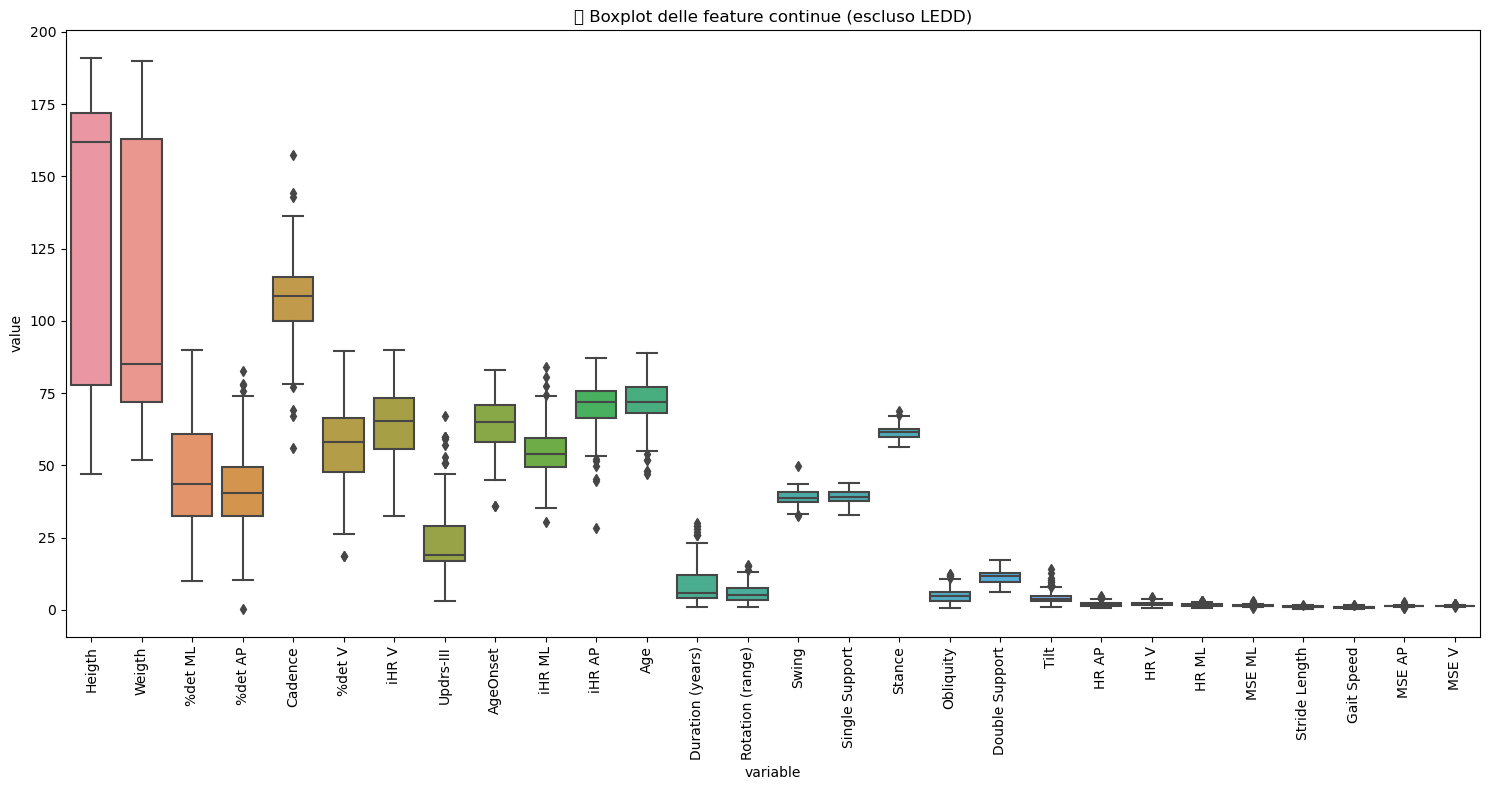

In [ ]:
print("📐 Shape finale del dataset:", df.shape)

# 1. Missing values
print("\n🔎 Valori NaN residui:")
nan_residui = df.isna().sum()[df.isna().sum() > 0]
if nan_residui.empty:
    print("✅ Nessun NaN residuo")
else:
    print(nan_residui)

# 2. Tipi di dato
print("\n📊 Tipi di dato:")
print(df.dtypes.value_counts())

# 3. Colonne non numeriche
non_numeric_cols = df.select_dtypes(exclude=["int64", "float64"]).columns
if len(non_numeric_cols) > 0:
    print("\n⚠️ Colonne non numeriche:", non_numeric_cols.tolist())
else:
    print("\n✅ Tutte le colonne sono numeriche")

# 4. Colonne con varianza nulla
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(df)
zero_var_cols = df.columns[~constant_filter.get_support()]
if len(zero_var_cols) > 0:
    print("\n⚠️ Colonne con varianza nulla:", zero_var_cols.tolist())
else:
    print("\n✅ Nessuna colonna con varianza nulla")

# 5. Statistiche descrittive (prime 10 righe, resto su CSV)
desc = df.describe().T
print("\n📈 Statistiche di base (prime 10 variabili):")
display(desc.head(10))
desc.to_csv("../tables/descriptive_postclean.csv")

# 6. Outlier check (boxplot ordinato per varianza, escluso LEDD)
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = [
    col for col in df.columns
    if df[col].nunique() > 10 and df[col].dtype in ['float64', 'int64'] and col != 'LEDD'
]

df_melted = pd.melt(df[cols_to_plot])
order = df[cols_to_plot].var().sort_values(ascending=False).index

plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=df_melted, order=order)
plt.xticks(rotation=90)
plt.title("📦 Boxplot delle feature continue (escluso LEDD)")
plt.tight_layout()
plt.show()

📊 Report outlier e skewness:


,n_outliers,skewness
MSE ML,21,1.288444
MSE AP,15,1.583064
Tilt,13,1.734350
Updrs-III,10,1.161684
Duration (years),8,1.242759
HR ML,8,0.740821
LEDD,7,0.856994
Cadence,7,-0.243337
MSE V,7,0.630230
iHR AP,6,-1.009242



✅ Feature selezionate per Winsorizing (14):
['MSE ML', 'MSE AP', 'Tilt', 'Updrs-III', 'HR ML', 'Cadence', 'MSE V', 'iHR AP', 'Age', 'Obliquity', '%det AP', 'iHR ML', 'HR AP', 'Rotation (range)']


/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_86127/3462885558.py:82: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from current font.
  plt.tight_layout()
/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_86127/3462885558.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


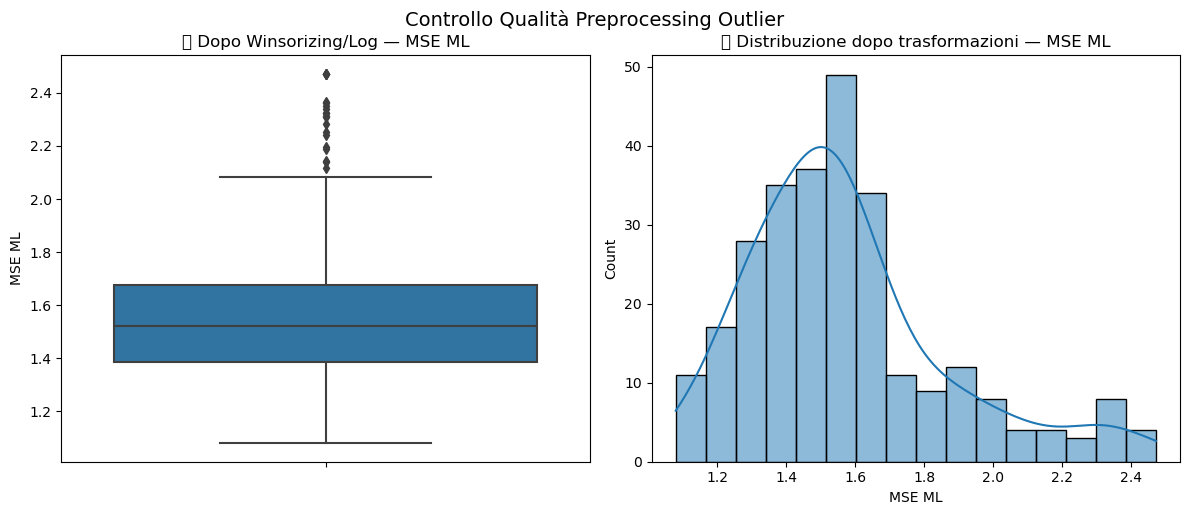

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# STEP 0 — Impostazioni
log_vars = [c for c in ["LEDD", "Duration (years)"] if c in df.columns]  # trasformazione log
ordinals_to_exclude = [c for c in ["OnsetCategory"] if c in df.columns]   # evita ordinali nei test outlier

# STEP 1 — Seleziona feature numeriche continue (no target/binari/ordinali)
cols_to_plot = [
    col for col in df.columns
    if df[col].dtype in ['float64', 'int64']
    and df[col].nunique() > 10
    and col not in ordinals_to_exclude
]

# STEP 2 — Funzione outlier via IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

# STEP 3 — Report outlier e skewness
outlier_report = {}
skew_report = {}
for col in cols_to_plot:
    outlier_report[col] = detect_outliers_iqr(df[col])
    skew_report[col] = skew(df[col], nan_policy='omit')

df_outlier_skew = pd.DataFrame({
    "n_outliers": pd.Series(outlier_report),
    "skewness": pd.Series(skew_report)
}).sort_values(by="n_outliers", ascending=False)

print("📊 Report outlier e skewness:")
display(df_outlier_skew)

# STEP 4 — Regole:
#   - log1p su LEDD e Duration (years)
#   - winsorize se (outlier > 3) o (|skew| > 1.5), escludendo le variabili loggate
def winsorize_series(series, lower_quantile=0.01, upper_quantile=0.99):
    lower = series.quantile(lower_quantile)
    upper = series.quantile(upper_quantile)
    return series.clip(lower, upper)

# 4a) Log-transform in-place (manteniamo lo stesso nome per semplicità)
for col in log_vars:
    df[col] = np.log1p(df[col])

# 4b) Selezione per winsorizing
candidates = df_outlier_skew[
    (df_outlier_skew["n_outliers"] > 3) | (df_outlier_skew["skewness"].abs() > 1.5)
].index.tolist()

features_to_winsorize = [c for c in candidates if c not in log_vars]

print(f"\n✅ Feature selezionate per Winsorizing ({len(features_to_winsorize)}):")
print(features_to_winsorize)

for col in features_to_winsorize:
    df[col] = winsorize_series(df[col])

# STEP 5 — Verifica visiva (sceglie la prima variabile modificata, se c'è; altrimenti una qualsiasi continua)
if len(features_to_winsorize) > 0:
    esempio = features_to_winsorize[0]
elif len(cols_to_plot) > 0:
    esempio = cols_to_plot[0]
else:
    esempio = None

if esempio is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.boxplot(y=df[esempio], ax=axes[0])
    axes[0].set_title(f"🟥 Dopo Winsorizing/Log — {esempio}")
    sns.histplot(df[esempio], ax=axes[1], kde=True)
    axes[1].set_title(f"📈 Distribuzione dopo trasformazioni — {esempio}")
    plt.tight_layout()
    plt.suptitle("Controllo Qualità Preprocessing Outlier", y=1.02, fontsize=14)
    plt.show()
else:
    print("ℹ️ Nessuna variabile disponibile per il plot di controllo.")

In [10]:
import pandas as pd
import numpy as np

# 🔹 Escludiamo target e variabili non adatte alla correlazione
exclude_cols = [
    "target_bin", "Hyposmia", "REM", "Depression", "Constipation",
    "ID", "Evaluation_Date", "AgeOnset", "OnsetCategory", 
    "LEDD", "Updrs_III"
]

X_numeriche = df.drop(columns=[col for col in exclude_cols if col in df.columns])

# 🔹 Calcolo della matrice di correlazione Spearman
corr_matrix = X_numeriche.corr(method="spearman")

# 🔹 Lista per salvare le coppie ad alta correlazione
correlated_pairs = []

threshold = 0.6  # più stringente

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            f1 = corr_matrix.columns[i]
            f2 = corr_matrix.columns[j]
            correlated_pairs.append((f1, f2, corr_value))

# 🔹 Ordinamento per forza di correlazione
correlated_df = pd.DataFrame(correlated_pairs, columns=["Feature_1", "Feature_2", "Spearman_r"])
correlated_df["|r|"] = correlated_df["Spearman_r"].abs()
correlated_df = correlated_df.sort_values(by="|r|", ascending=False).drop(columns="|r|")

# 🔹 Output
print(f"🔎 Coppie di feature con Spearman > {threshold}:")
display(correlated_df)

🔎 Coppie di feature con Spearman > 0.6:


,Feature_1,Feature_2,Spearman_r
6,Swing,Single Support,0.972521
3,Stance,Double Support,0.957800
2,Stance,Swing,-0.908118
4,Stance,Single Support,-0.907161
7,Double Support,Single Support,-0.906492
5,Swing,Double Support,-0.896586
9,Updrs_III_was_missing,missing_flags_sum,0.874947
0,HR V,HR AP,0.749887
8,Stride Length,Gait Speed,0.707019
1,Updrs-III,H-Y,0.625025


🔧 FS: partiamo da 29 feature (dopo esclusioni).


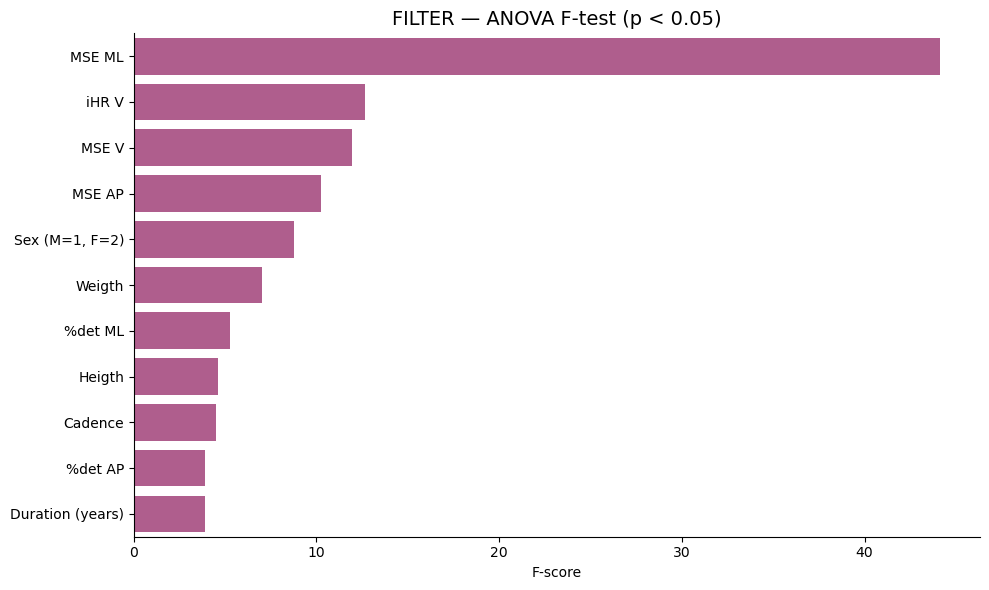

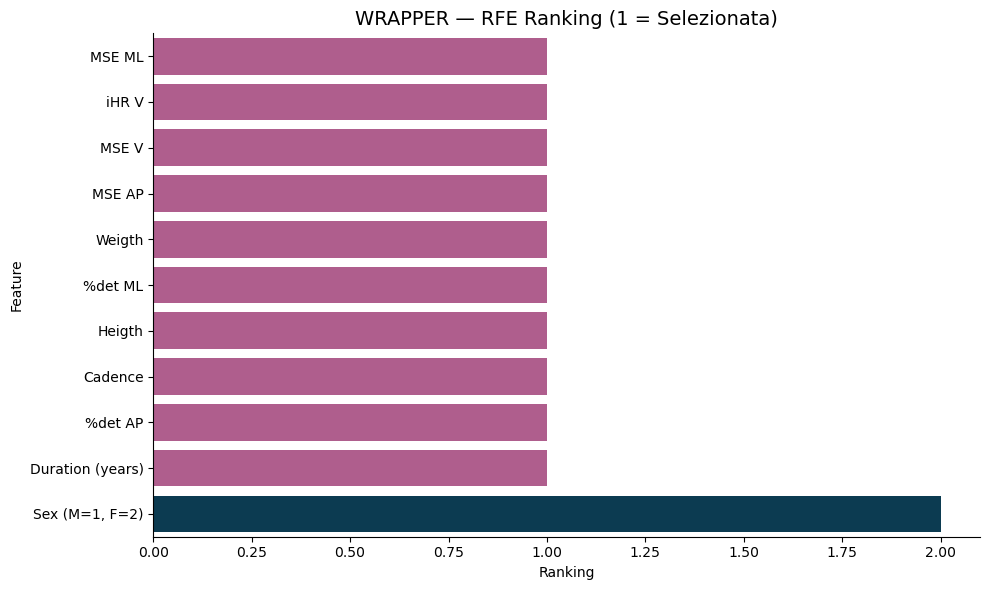

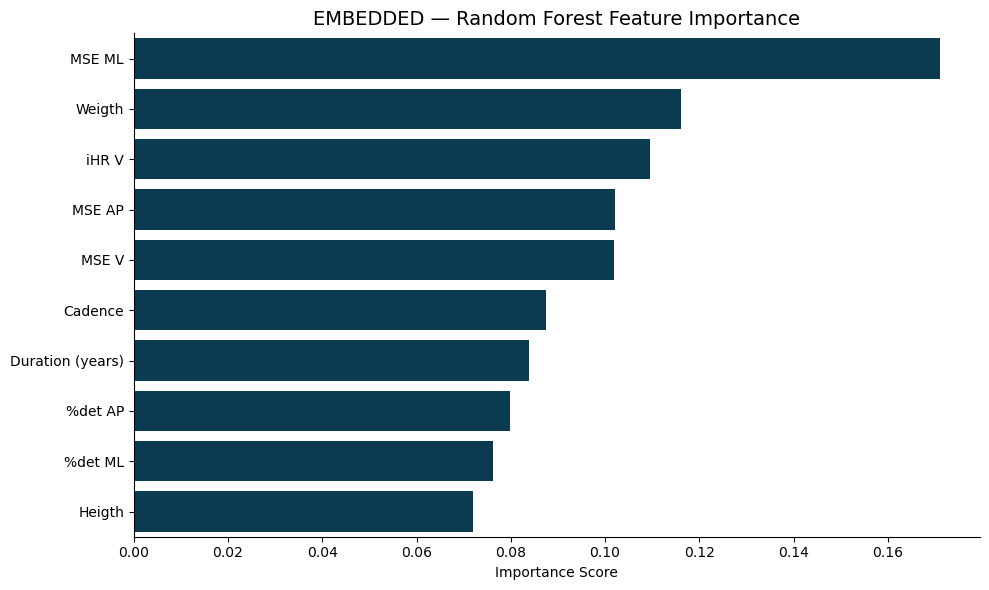

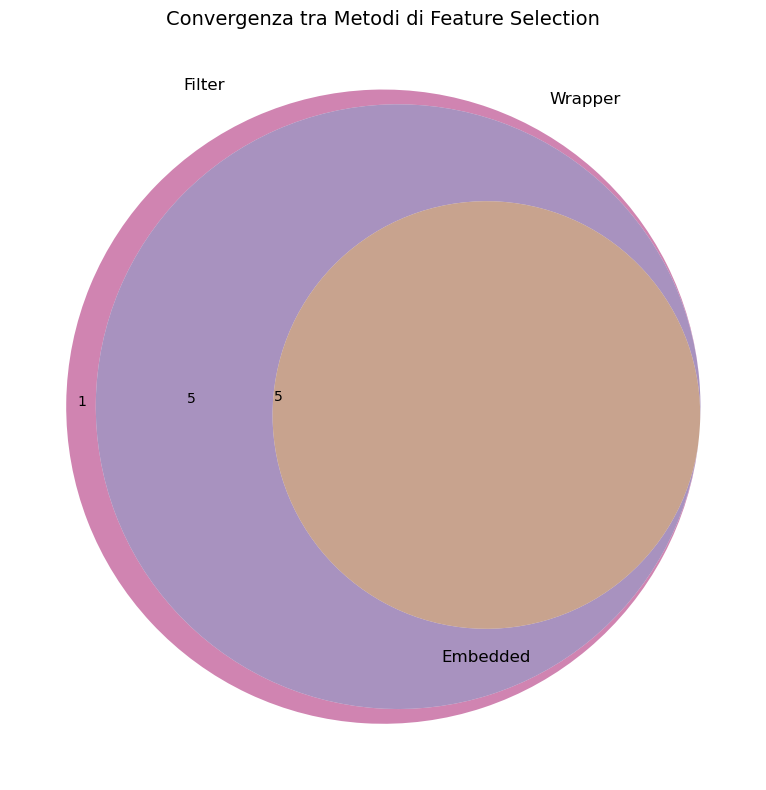

✅ FILTER → 11 feature selezionate
✅ WRAPPER → 10 feature selezionate
✅ EMBEDDED → 5 feature finali top

🎯 FEATURE SELEZIONATE (da passare a CTGAN / modelli):
['MSE ML', 'Weigth', 'iHR V', 'MSE AP', 'MSE V']

📊 Tabella dettagliata (Filter/Wrapper/Embedded):
                                                                                  F_score       p_value RFE_ranking Importance  Filter_selected  Wrapper_selected  Embedded_selected  Totale_metodi
MSE ML                                                                          44.112035  1.681160e-10         1.0   0.171007                1                 1                  1              3
Weigth                                                                           7.014016  8.559928e-03         1.0   0.116017                1                 1                  1              3
iHR V                                                                           12.662280  4.401027e-04         1.0   0.109468                1            

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# --- Palette e label ---
palette = {0: "#003f5c", 1: "#bc5090"}
main_color = palette[1]
alt_color  = palette[0]

# ======================
# STEP 0 — Rimozione feature non utilizzabili / ridondanti (logica aggiornata)
# ======================

# a) Colonne da escludere (identificativi, target, prodromi, cliniche pure)
base_exclude = [
    "target_bin", "ID", "Surname", "Name", "Center", "Evaluation_Date", "ProdromalCount",
    "Constipation", "Hyposmia", "REM", "Depression",
    "Updrs-III", "H-Y"  # scale cliniche (le useremo come covariate nei modelli, non nella FS biomeccanica)
]

# b) Ridondanze note (da analisi di collinearità): tieni Gait Speed, droppa Stride Length; droppa Stance & Swing; tra HRV/HRAP tieni HR V
redundant_cols = [
    "Stance", "Swing", "Gait Speed", "HR AP"
]

# c) Eventuali flag di missingness
flag_cols = [c for c in df.columns if c.endswith("_was_missing") or c == "missing_flags_sum"]

cols_to_drop = [c for c in (base_exclude + redundant_cols + flag_cols) if c in df.columns]

df_filtered = df.drop(columns=cols_to_drop, errors="ignore").copy()

# X e y
y = df["target_bin"].astype(int)
X = df_filtered.copy()

print(f"🔧 FS: partiamo da {X.shape[1]} feature (dopo esclusioni).")

# ======================
# STEP 1 — FILTER: ANOVA F-test
# ======================

filter_selector = SelectKBest(score_func=f_classif, k="all")
filter_selector.fit(X, y)

filter_scores = pd.DataFrame({
    "Feature": X.columns,
    "F_score": filter_selector.scores_,
    "p_value": filter_selector.pvalues_
}).sort_values(by="F_score", ascending=False)

features_filter = filter_scores.query("p_value < 0.05")["Feature"].tolist()

# GRAFICO 1 — Barplot F-score (solo significanti)
plt.figure(figsize=(10, 6))
sig_df = filter_scores.query("p_value < 0.05").copy()
sns.barplot(data=sig_df, x="F_score", y="Feature", color=main_color)
plt.title("FILTER — ANOVA F-test (p < 0.05)", fontsize=14)
plt.xlabel("F-score"); plt.ylabel("")
sns.despine(); plt.tight_layout(); plt.show()

# ======================
# STEP 2 — WRAPPER: RFE con RandomForest
# ======================

# Selezioniamo solo le feature passate dal filtro (se vuote, fallback a tutte)
X_filter = X[features_filter] if len(features_filter) > 0 else X.copy()

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator=rf_clf, n_features_to_select=min(10, X_filter.shape[1]), step=1)
rfe_selector.fit(X_filter, y)

features_wrapper = X_filter.columns[rfe_selector.support_].tolist()

# GRAFICO 2 — Ranking RFE (1 = selezionata)
rfe_ranking = pd.Series(rfe_selector.ranking_, index=X_filter.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_ranking.values, y=rfe_ranking.index, palette=[alt_color if r>1 else main_color for r in rfe_ranking.values])
plt.title("WRAPPER — RFE Ranking (1 = Selezionata)", fontsize=14)
plt.xlabel("Ranking"); plt.ylabel("Feature")
sns.despine(); plt.tight_layout(); plt.show()

# ======================
# STEP 3 — EMBEDDED: Feature Importance da RF
# ======================

rf_clf.fit(X_filter[features_wrapper], y)
importances = rf_clf.feature_importances_

df_importance = pd.DataFrame({
    "Feature": features_wrapper,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

mean_importance = df_importance["Importance"].mean()
features_embedded = df_importance.loc[df_importance["Importance"] > mean_importance, "Feature"].tolist()

# GRAFICO 3 — Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance, x="Importance", y="Feature", color=alt_color)
plt.title("EMBEDDED — Random Forest Feature Importance", fontsize=14)
plt.xlabel("Importance Score"); plt.ylabel("")
sns.despine(); plt.tight_layout(); plt.show()

# ======================
# STEP 4 — VENN Diagram
# ======================

plt.figure(figsize=(8, 8))
venn3(
    [set(features_filter), set(features_wrapper), set(features_embedded)],
    set_labels=("Filter", "Wrapper", "Embedded"),
    set_colors=(main_color, alt_color, "#ffa600"),
    alpha=0.7
)
plt.title("Convergenza tra Metodi di Feature Selection", fontsize=14)
plt.tight_layout(); plt.show()

# ======================
# STEP 5 — Output finale
# ======================

df_selected = df[features_embedded + ["target_bin"]].copy()

print("✅ FILTER →", len(features_filter), "feature selezionate")
print("✅ WRAPPER →", len(features_wrapper), "feature selezionate")
print("✅ EMBEDDED →", len(features_embedded), "feature finali top")
print("\n🎯 FEATURE SELEZIONATE (da passare a CTGAN / modelli):")
print(features_embedded)

# ======================
# STEP 6 — Tabella completa con valori numerici
# ======================

# 1) F-Score + p-value (Filter)
filter_data = filter_scores.set_index("Feature")[["F_score", "p_value"]]

# 2) RFE ranking (Wrapper)
rfe_data = pd.DataFrame({"RFE_ranking": rfe_selector.ranking_}, index=X_filter.columns)

# 3) Feature Importance (Embedded)
embedded_data = df_importance.set_index("Feature")[["Importance"]]

# Unione e indicatori di selezione
summary_df_complete = pd.concat([filter_data, rfe_data, embedded_data], axis=1)
summary_df_complete["Filter_selected"]   = summary_df_complete.index.isin(features_filter).astype(int)
summary_df_complete["Wrapper_selected"]  = summary_df_complete.index.isin(features_wrapper).astype(int)
summary_df_complete["Embedded_selected"] = summary_df_complete.index.isin(features_embedded).astype(int)
summary_df_complete["Totale_metodi"]     = summary_df_complete[["Filter_selected","Wrapper_selected","Embedded_selected"]].sum(axis=1)

summary_df_complete = summary_df_complete.sort_values(by=["Totale_metodi","Importance","F_score"], ascending=[False, False, False])

print("\n📊 Tabella dettagliata (Filter/Wrapper/Embedded):")
print(summary_df_complete.fillna("").to_string())

# (Opzionale) salvataggio
# summary_df_complete.to_excel("../output/feature_selection/riepilogo_feature_selection_completo.xlsx")
# df_selected.to_csv("../output/feature_selection/selected_features_embedded.csv", index=False)

In [12]:
import pandas as pd

# 🔹 CORE FEATURES (selezionate da Filter + Wrapper + Embedded)
core_features = [
    "MSE ML", 
    "iHR V", 
    "MSE V", 
    "MSE AP", 
    "Weigth"
]

# 🔹 COVARIATE CLINICHE (per aggiustamento nei modelli)
covariates = [
    "Age",
    "Sex (M=1, F=2)",
    "H-Y",
    "Gait Speed",
    "Duration (years)"
]

# 🔹 Variabili target / prodromi
targets = [
    "target_bin",      # triade vs non-triade
    "Constipation", 
    "Hyposmia", 
    "REM", 
    "Depression"
]

# === 1. Dataset core (solo feature principali + target) ===
df_core = df[core_features + ["target_bin"]].copy()

# === 2. Dataset core + covariates (per modelli supervisionati) ===
df_core_cov = df[core_features + covariates + ["target_bin"]].copy()

# === 3. Dataset completo con prodromi (per analisi descrittive) ===
df_with_prodromi = df[core_features + covariates + targets].copy()

# 🔹 Percorsi di output
csv_core = "../data/processed/dataset_core.csv"
xlsx_core = "../data/processed/dataset_core.xlsx"

csv_cov = "../data/processed/dataset_core_covariates.csv"
xlsx_cov = "../data/processed/dataset_core_covariates.xlsx"

csv_prod = "../data/processed/dataset_with_prodromi.csv"
xlsx_prod = "../data/processed/dataset_with_prodromi.xlsx"

# 🔹 Salvataggi
df_core.to_csv(csv_core, index=False)
df_core.to_excel(xlsx_core, index=False)

df_core_cov.to_csv(csv_cov, index=False)
df_core_cov.to_excel(xlsx_cov, index=False)

df_with_prodromi.to_csv(csv_prod, index=False)
df_with_prodromi.to_excel(xlsx_prod, index=False)

print("✅ Dataset salvati in:")
print(f"- Core: {csv_core} / {xlsx_core}")
print(f"- Core + covariate: {csv_cov} / {xlsx_cov}")
print(f"- Core + covariate + prodromi: {csv_prod} / {xlsx_prod}")

✅ Dataset salvati in:
- Core: ../data/processed/dataset_core.csv / ../data/processed/dataset_core.xlsx
- Core + covariate: ../data/processed/dataset_core_covariates.csv / ../data/processed/dataset_core_covariates.xlsx
- Core + covariate + prodromi: ../data/processed/dataset_with_prodromi.csv / ../data/processed/dataset_with_prodromi.xlsx
